# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../input/seg_train/seg_train', '../input/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  1%|          | 23/2274 [00:00<00:09, 226.56it/s]

Loading ../input/seg_train/seg_train


  6%|▌         | 30/510 [00:00<00:01, 296.25it/s]

Loading ../input/seg_test/seg_test


100%|██████████| 501/501 [00:01<00:00, 320.82it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

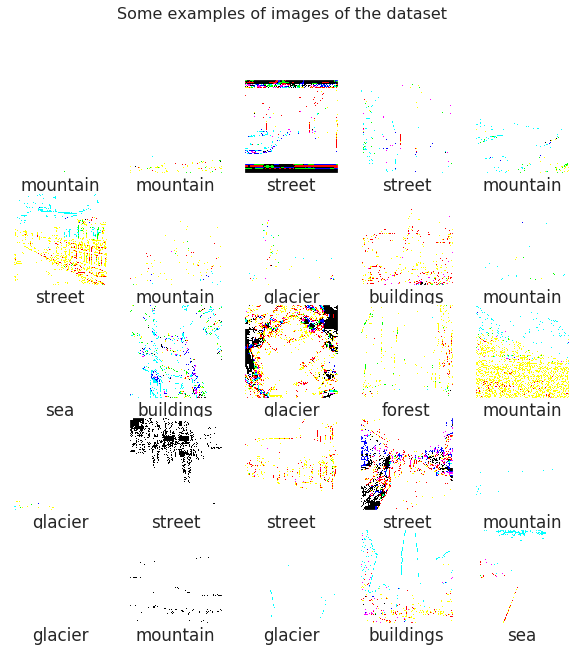

In [7]:
display_examples(class_names, train_images, train_labels)

## Good practice: scale the data

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])    
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])



categories = [0, 1, 2, 3, 4, 5]
BATCH_SIZE = 100
TEST_RESULTS = []

for i in range(5):
    # Creating the Sample
    start, end = i*BATCH_SIZE, (i+1)*BATCH_SIZE
    test_start, test_end = (i+1)*BATCH_SIZE, (i+2)*BATCH_SIZE
    itr_train_images = []
    itr_train_labels = []
    idxs = []
    test_idxs = []
    for category in categories:
        temp = np.where(train_labels == category)[0][start:end]
        test_temp = np.where(train_labels == category)[0][test_start:test_end]
        idxs.extend(temp)
        test_idxs.extend(test_temp)

    itr_train_images = np.array(train_images[idxs])
    itr_train_labels = np.array(train_labels[idxs])        
    itr_train_images, itr_train_labels = shuffle(itr_train_images, itr_train_labels, random_state=25)

    history = model.fit(
        itr_train_images,
        itr_train_labels,
        batch_size=10, 
        epochs=5, 
        validation_split = 0.2)   
    
#     # Testing on the next 100 images
#     TEST_RESULTS.append(
#         model.evaluate(
#             np.array(train_images[test_idxs]),
#             np.array(train_labels[test_idxs])
#         )
#     )
    from sklearn.metrics import accuracy_score

    predictions = model.predict(np.array(train_images[test_idxs]))    
    pred_labels = np.argmax(predictions, axis = 1)
    TEST_RESULTS.append("Accuracy : {}".format(
        accuracy_score(
            np.array(train_labels[test_idxs]), 
            pred_labels
        )
    ))

Train on 480 samples, validate on 120 samples
Epoch 1/5
480/480 [==============================] - 1s 2ms/sample - loss: 1.8013 - acc: 0.3167 - val_loss: 1.4586 - val_acc: 0.3333
Epoch 2/5
480/480 [==============================] - 0s 852us/sample - loss: 1.2604 - acc: 0.5042 - val_loss: 1.3570 - val_acc: 0.4083
Epoch 3/5
480/480 [==============================] - 0s 851us/sample - loss: 0.9836 - acc: 0.6521 - val_loss: 1.1679 - val_acc: 0.5500
Epoch 4/5
480/480 [==============================] - 0s 864us/sample - loss: 0.5839 - acc: 0.8021 - val_loss: 1.1033 - val_acc: 0.5917
Epoch 5/5
480/480 [==============================] - 0s 847us/sample - loss: 0.3820 - acc: 0.8833 - val_loss: 1.3521 - val_acc: 0.5417
Train on 480 samples, validate on 120 samples
Epoch 1/5
480/480 [==============================] - 0s 850us/sample - loss: 1.3841 - acc: 0.5333 - val_loss: 1.4231 - val_acc: 0.5083
Epoch 2/5
480/480 [==============================] - 0s 852us/sample - loss: 0.8461 - acc: 0.7021 - 

In [51]:
TEST_RESULTS

['Accuracy : 0.565',
 'Accuracy : 0.595',
 'Accuracy : 0.6683333333333333',
 'Accuracy : 0.6466666666666666',
 'Accuracy : 0.6616666666666666']

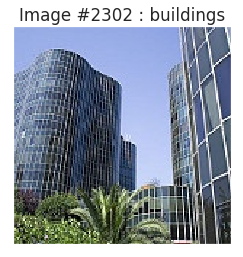

In [46]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)